# HW 4 Nonparametric Regression and Classification


Please complete this notebook by filling in the cells provided. Before you begin, execute the following cell to load required modules. Each time you start your server, you will need to execute the below cell again to load the modules.


We will work with a single dataset
1. fb - This dataset counts how many comments a post on facebook recieves in the next 24 hours. https://archive.ics.uci.edu/ml/datasets/Facebook+Comment+Volume+Dataset


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
from sklearn.preprocessing import OneHotEncoder
def brier_score(targets, probs):
  enc = OneHotEncoder()
  target_enc = enc.fit_transform(np.array(targets).reshape(-1, 1)).toarray()
  return np.mean(np.sum((probs - target_enc)**2, axis=1))

def log_score(targets, probs):
  enc = OneHotEncoder()
  target_enc = enc.fit_transform(np.array(targets).reshape(-1, 1)).toarray()
  return -np.mean(np.sum(target_enc * np.log(probs + 1e-32), axis=1))

# Question 1 - Trending posts (regression)

Suppose we are a machine learning engineer at Facebook. Our task is to identify posts that are trending so that we can promote them. We will say that a post is trending if we predict it will be "highly active" over the next 24 hours.

We gather the following dataset https://archive.ics.uci.edu/ml/datasets/Facebook+Comment+Volume+Dataset

- This dataset contains features about the page that posted, how many comments the post has already recieved, what day it was posted on, and more.

- The dataset also contains the number of comments the post recieved over the next H hours.


In our first attempt we will use regression to predict how many comments a post will recieve in the next 24 hours.






In [ ]:
# run this to download the data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00363/Dataset.zip

import zipfile
with zipfile.ZipFile("Dataset.zip", "r") as zip_ref:
  zip_ref.extractall(".")

!rm Dataset.zip

--2023-11-01 21:40:53--  https://archive.ics.uci.edu/ml/machine-learning-databases/00363/Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘Dataset.zip’

Dataset.zip             [    <=>             ]  18.17M  28.5MB/s    in 0.6s    

2023-11-01 21:40:54 (28.5 MB/s) - ‘Dataset.zip’ saved [19055526]



In [ ]:
# only going to use "variant 1"
fb = pd.read_csv('Dataset/Training/Features_Variant_1.csv', header = None)

In [ ]:
# painstakingly extracted the feature names
# credit: https://github.com/wusixuan2/facebook-comment-volume-prediction/blob/master/dataset/FeatureNames.csv

features = ['Page Popularity Likes',
'Page Checkins',
'Page Talking About',
'Page Category',
'CC1 Min',
'CC1 Max',
'CC1 Avg',
'CC1 Median',
'CC1 Std',
'CC2 Min',
'CC2 Max',
'CC2 Avg',
'CC2 Median',
'CC2 Std',
'CC3 Min',
'CC3 Max',
'CC3 Avg',
'CC3 Median',
'CC3 Std',
'CC4 Min',
'CC4 Max',
'CC4 Avg',
'CC4 Median',
'CC4 Std',
'CC5 Min',
'CC5 Max',
'CC5 Avg',
'CC5 Median',
'CC5 Std',
'CC1',
'CC2',
'CC3',
'CC4',
'CC5',
'Base Time',
'Post Length',
'Post Share Count',
'Post Promotion Status',
'Hours Local',
'Posted Sunday',
'Posted Monday',
'Posted Tuesday',
'Posted Wednesday',
'Posted Thursday',
'Posted Friday',
'Posted Saturday',
'Selected Sunday',
'Selected Monday',
'Selected Tuesday',
'Selected Wednesday',
'Selected Thursday',
'Selected Friday',
'Selected Saturday',
'Comments'
]
fb.columns = features

## Part a

We notice that some of the posts in our data were deleted before 24 hours was up. Lets remove these since were interested in how many comments appear in the next 24 hours.

1. Filter the data down to only those posts that we allowed to accumulate comments for 24 hours.

i.e. remove any posts with `Hours local` < 24

In [ ]:
fb = fb[fb['Hours Local'] >= 24]
fb.head()

,Page Popularity Likes,Page Checkins,Page Talking About,Page Category,CC1 Min,CC1 Max,CC1 Avg,CC1 Median,CC1 Std,CC2 Min,...,Posted Friday,Posted Saturday,Selected Sunday,Selected Monday,Selected Tuesday,Selected Wednesday,Selected Thursday,Selected Friday,Selected Saturday,Comments
0,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,0,0,0,0,0,0,0,0,1,0
1,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,0,0,0,0,0,0,0,1,0,0
2,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,1,0,0,0,0,0,0,0,1,0
3,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,1,0,0,1,0,0,0,0,0,0
4,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,0,0,0,0,0,1,0,0,0,0


## Part b

We then notice that there are a ton of features in this dataset, many of which are undocumented. Lets remove these too, so we can explain our findings.

1. Remove all columns from `fb` except

      'Page Popularity Likes', 'Page Checkins', 'Page Talking About', 'Page Category', 'CC1', 'CC2', 'CC3', 'CC4', 'CC5', 'Post Length', 'Post Share Count', 'Post Promotion Status', 'Posted Monday', 'Posted Tuesday', 'Posted Wednesday', 'Posted Thursday','Posted Friday', 'Posted Saturday', 'Comments'

2. Print the head of the updated dataset

In [ ]:
features2 = ['Page Popularity Likes', 'Page Checkins', 'Page Talking About', 'Page Category', 'CC1', 'CC2', 'CC3', 'CC4', 'CC5', 'Post Length', 'Post Share Count', 'Post Promotion Status', 'Posted Monday', 'Posted Tuesday', 'Posted Wednesday', 'Posted Thursday','Posted Friday', 'Posted Saturday', 'Comments']
fb = fb.loc[:, features2]
fb.head()

,Page Popularity Likes,Page Checkins,Page Talking About,Page Category,CC1,CC2,CC3,CC4,CC5,Post Length,Post Share Count,Post Promotion Status,Posted Monday,Posted Tuesday,Posted Wednesday,Posted Thursday,Posted Friday,Posted Saturday,Comments
0,634995,0,463,1,0,0,0,0,0,166,2,0,0,0,1,0,0,0,0
1,634995,0,463,1,0,0,0,0,0,132,1,0,0,0,0,1,0,0,0
2,634995,0,463,1,0,0,0,0,0,133,2,0,0,0,0,0,1,0,0
3,634995,0,463,1,7,0,3,7,-3,131,1,0,0,0,0,0,1,0,0
4,634995,0,463,1,1,0,0,1,0,142,5,0,1,0,0,0,0,0,0


## Part c

1. Split `fb` into x and y where `y` is the column `comments` and `x` is every other column

2. Split x and y into training and testing data with test_size = 0.33 and random_state = 42

In [ ]:
y = fb['Comments']
x = fb.drop(columns=['Comments'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

## Part d

Fit a random forest and decision tree regressor. Use random_state = 42 for each model.

1. For the random forest, tune the parameters (n_estimators, max_features, max_depth, min_samples_split) until your test MSE is $ < 700$

2. For the decision tree, tune the parameters (max_depth, min_samples_split) until test MSE is $< 900$

3. Print the test MSE of each (tuned) model

In [ ]:
# fit
dtr = DecisionTreeRegressor(max_depth=5, min_samples_split=6, random_state=42)
dtr.fit(x_train, y_train)

rfr = RandomForestRegressor(n_estimators=100, max_features='log2', max_depth=None, min_samples_split=2, random_state=42)
rfr.fit(x_train, y_train)

RandomForestRegressor(max_features='log2', random_state=42)

In [ ]:
# predict
yhat_train_dt = dtr.predict(x_train).squeeze()
yhat_test_dt = dtr.predict(x_test).squeeze()

yhat_train_rf = rfr.predict(x_train).squeeze()
yhat_test_rf = rfr.predict(x_test).squeeze()

In [ ]:
# MSE
print('Decision Tree')
print('Test MSE: ', np.mean((np.array(y_test) - yhat_test_dt)**2))
print('')
print('Random Forest')
print('Test MSE: ', np.mean((np.array(y_test) - yhat_test_rf)**2))

Decision Tree
Test MSE:  827.4646878073584

Random Forest
Test MSE:  686.9461066217848


## Part e

Print a table showing the variable importance of each feature for the random forest (RF) and the decision tree (DT) algorithm.

1. Each row should show the variable name, the RF importance, and the DT importance.

2. Comment on the differences between what is important to the RF and what is important to the DT. Your response should be several sentences long.

You can find definitions of CC1-CC5 here https://archive.ics.uci.edu/ml/datasets/Facebook+Comment+Volume+Dataset

In [ ]:
importance = pd.DataFrame({'Variable':x.columns,
                           'DT Importance':dtr.feature_importances_,
                           'RF Importance':rfr.feature_importances_})
importance

,Variable,DT Importance,RF Importance
0,Page Popularity Likes,0.009154,0.063745
1,Page Checkins,0.020875,0.033053
2,Page Talking About,0.071374,0.085700
3,Page Category,0.000000,0.040196
4,CC1,0.123135,0.092450
5,CC2,0.608690,0.149225
6,CC3,0.000000,0.033589
7,CC4,0.064797,0.089307
8,CC5,0.029513,0.150713
9,Post Length,0.001200,0.065730


In the Random forest regression the feature importance is much more evenly distribute with 'CC2', 'CC5', and 'Post Share Count' being the 3 most important features and 'Share Count' (the highest importance' having only a value of about .15. Meanwhile, the decision tree regressor seems to be much more susceptible to the influence of individual high-ranking features as 'CC2' is the highest feature with an importance of over .6. This shows how random forest takes a more balanced approach while decision trees have more binary splits. With one feature showing up as so important in decision trees it makes a lot of the other features have a lower importance than in the random forest. There does atleast appear to be similarity in what features both forms of regression view as important.

# Question 2 - Trending posts (Classification)

With our regression models, we can do a relatively okay job of predicting how many comments a post will recieve in the next 24 hours.

However, we quickly realize that this isnt very useful and doesn't answer the question "which posts will be highly active in the future?".

Instead, lets rephrase this as a classification problem.
- We need to start with a definition of what "highly active" means.
- We will define "highly active post" to mean the post is in the top 5\% (by number of comments) of all posts in the next 24 hours.
- We can train classifiers on this objective (top 5\% directly)


## Part a

Create a vector called `y_class` that indicates if a post is in the top 5\% of all posts in the next 24 hours. This vector should be `1` if you are in the top 5\% and `0` otherwise.

1. Plot a histogram of `y_class`. How imbalanced is `y_class`?
y_class is very imbalanced as most values are 0.

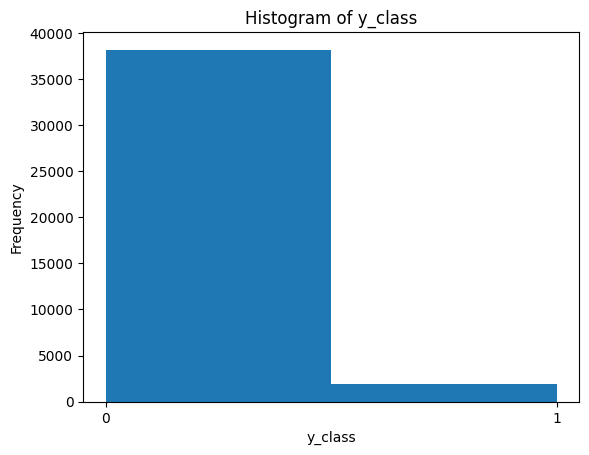

In [ ]:
y_class = np.array(fb.loc[:,['Comments']].values > np.quantile(fb.loc[:,['Comments']].values, 0.95), dtype = int)

# histogram
plt.hist(y_class, bins=2)
plt.xlabel("y_class")
plt.ylabel("Frequency")
plt.xticks([0, 1])
plt.title("Histogram of y_class")
plt.show()

your comments here

## Part b

Split data into train and test with a test_size = 0.33 and random_sate = 42

Fit the following models
1. Random forest classifier
2. Decision tree classifier
3. Linear Discriminant Analysis
4. Quadratic Disciminant Analysis
5. Logistic Regression

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y_class, test_size=0.33, random_state=42)

In [ ]:
# fit
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(x_train, y_train)

dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(x_train, y_train)

lda_classifier = LDA()
lda_classifier.fit(x_train, y_train)

qda_classifier = QDA()
qda_classifier.fit(x_train, y_train)

logistic_classifier = LogisticRegression(random_state=42)
logistic_classifier.fit(x_train, y_train)

LogisticRegression(random_state=42)

## Part c

Use each of the five models to predict the class labels (1 or 0) and the class probabilities on the test set. You do not need to calculate for the training dataset.

In [ ]:
# predict labels (1 or 0)
rf_labels = rf_classifier.predict(x_test)
dt_labels = dt_classifier.predict(x_test)
lda_labels = lda_classifier.predict(x_test)
qda_labels = qda_classifier.predict(x_test)
logistic_labels = logistic_classifier.predict(x_test)

# predict proba
rf_probabilities = rf_classifier.predict_proba(x_test)
dt_probabilities = dt_classifier.predict_proba(x_test)
lda_probabilities = lda_classifier.predict_proba(x_test)
qda_probabilities = qda_classifier.predict_proba(x_test)
logistic_probabilities = logistic_classifier.predict_proba(x_test)

## Part d

Compute and print

1. The test accuracy of each model
2. The test Brier score of each model
3. The test log score of each model

Make sure each print statement clearly indicates the model type (random forest, decision tree, etc.) and rounds to 3 decimal places.

Comment on which model is the best based on these metrics and which is the worst. If no model dominates the other in terms of Brier and Log score then comment on which two models are "equally" best. Your response should be several sentences long.



In [ ]:
# accuracy
print('Test Accuracy')
print('')
print('Logistic')
logit_accuracy_test = metrics.classification_report(y_test, logistic_labels, output_dict=True)['accuracy']
print(logit_accuracy_test)
print('LDA')
lda_accuracy_test = metrics.classification_report(y_test, lda_labels, output_dict=True)['accuracy']
print(lda_accuracy_test)
print('QDA')
qda_accuracy_test = metrics.classification_report(y_test, qda_labels, output_dict=True)['accuracy']
print(qda_accuracy_test)
print('Random Forest')
rf_accuracy_test = metrics.classification_report(y_test, rf_labels, output_dict=True)['accuracy']
print(rf_accuracy_test)
print('Decision Tree')
dt_accuracy_test = metrics.classification_report(y_test, dt_labels, output_dict=True)['accuracy']
print(dt_accuracy_test)

Test Accuracy

Logistic
0.9473485705664931
LDA
0.9640944406728521
QDA
0.26604812551859397
Random Forest
0.9678660330391491
Decision Tree
0.9535339820472203


In [ ]:
# brier
print('Brier score test')
print('')
print('Logistic:', np.round(brier_score(y_test, logistic_probabilities), 3))
print('LDA:', np.round(brier_score(y_test, lda_probabilities), 3))
print('QDA:', np.round(brier_score(y_test, qda_probabilities), 3))
print('Random Forest:', np.round(brier_score(y_test, rf_probabilities), 3))
print('Decision Tree:', np.round(brier_score(y_test, dt_probabilities), 3))

Brier score test

Logistic: 0.145
LDA: 0.064
QDA: 1.455
Random Forest: 0.046
Decision Tree: 0.093


In [ ]:
# log
print('')
print('Log score test')
print('')
print('Logistic:', np.round(log_score(y_test, logistic_probabilities), 3))
print('LDA:', np.round(log_score(y_test, lda_probabilities), 3))
print('QDA:', np.round(log_score(y_test, qda_probabilities), 3))
print('Random Forest:', np.round(log_score(y_test, rf_probabilities), 3))
print('Decision Tree:', np.round(log_score(y_test, dt_probabilities), 3))


Log score test

Logistic: 0.314
LDA: 0.185
QDA: 44.055
Random Forest: 0.134
Decision Tree: 3.424


The clear worst model was QDA with an accuracy of just .26 while all other models had an accuracy of .94 or higher. QDA also had the highest log and brier score by a lot confirming that it is the worst model. The two best models seem to be LDA and Random Forest and Random Forest does appear to be slightly better in all metrics. So Random Forest is the best model with the highest accuracy of .967, lowest brier score of .046, and the lowest log score of .134.


## Part e

Maybe theres no clear winner or maybe you think these metrics are "too close to call", so we invesigate these models further by looking at their ROC curves and AUC.

Compute and show

1. The ROC curve for each model (all overlaid in one plot)
2. The AUC for each model (print and label)

Comment on how these models compare in terms of ROC and AUC.  Your response should be several sentences long.

In [ ]:
# compute roc curves
fpr_lda, tpr_lda, thresholds = roc_curve(y_test, lda_probabilities[:,1])
fpr_qda, tpr_qda, thresholds = roc_curve(y_test, qda_probabilities[:,1])
fpr_logistic, tpr_logistic, thresholds = roc_curve(y_test, logistic_probabilities[:,1])
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, rf_probabilities[:,1])
fpr_dt, tpr_dt, thresholds = roc_curve(y_test, dt_probabilities[:,1])

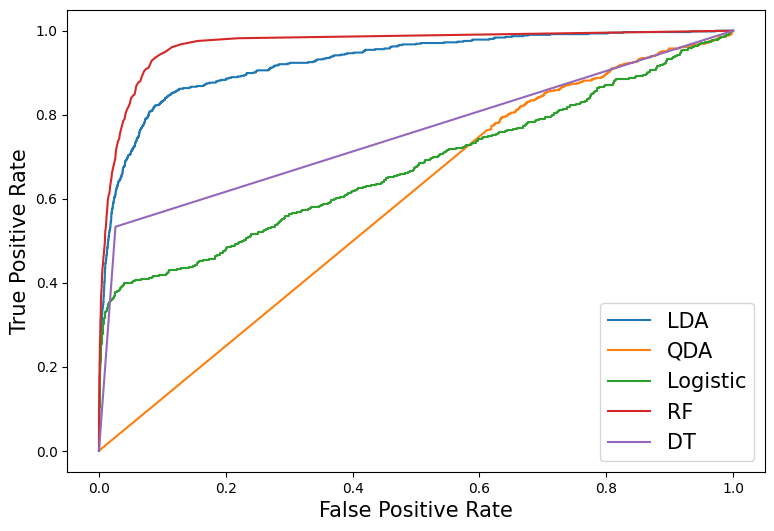

In [ ]:
# plot and label roc curves
# plt each roc curve on the same figure
plt.figure(figsize = (9, 6))
plt.plot(fpr_lda, tpr_lda, label = 'LDA')
plt.plot(fpr_qda, tpr_qda, label = 'QDA')
plt.plot(fpr_logistic, tpr_logistic, label = 'Logistic')
plt.plot(fpr_rf, tpr_rf, label = 'RF')
plt.plot(fpr_dt, tpr_dt, label = 'DT')
plt.xlabel('False Positive Rate', fontsize = 15)
plt.ylabel('True Positive Rate', fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

In [ ]:
# auc
print('Area under the curve (AUC)')
print('')
print('LDA:', np.round(roc_auc_score(y_test, lda_probabilities[:,1]), 4))
print('QDA:', np.round(roc_auc_score(y_test, qda_probabilities[:,1]), 4))
print('Logistic Regression:', np.round(roc_auc_score(y_test, logistic_probabilities[:,1]), 4))
print('RF:', np.round(roc_auc_score(y_test, rf_probabilities[:,1]), 4))
print('DT:', np.round(roc_auc_score(y_test, dt_probabilities[:,1]), 4))

Area under the curve (AUC)

LDA: 0.9271
QDA: 0.582
Logistic Regression: 0.6738
RF: 0.9674
DT: 0.7537


When looking at ROC and AUC for our models we can clearly see that the ROC curve for random forest shows much higher accuracy than the other models and it has a much larger area under the curve than the other models. This confirms the idea that Random forest is our best model based on all of the metrics. The ROC and AUC also confirm that QDA is the worst model.

## Part f

Suppose we ultimately choose the random forest regarless of your findings above. (your boss says you have to)

Lets see what the random forest think is important

1. Print the feature importance of each feature in a table format. Each row should include the feature name and its importance to the RF classifier

In [ ]:
importance = pd.DataFrame({'Variable':x.columns,
                           'RF Importance':rf_classifier.feature_importances_})
importance

,Variable,RF Importance
0,Page Popularity Likes,0.062210
1,Page Checkins,0.034585
2,Page Talking About,0.074142
3,Page Category,0.035997
4,CC1,0.075477
5,CC2,0.211837
6,CC3,0.041065
7,CC4,0.083088
8,CC5,0.166030
9,Post Length,0.069481


## Part g

That list tells us what is important but not what makes it important

Lets investigate a single feature -- `Post Length`

1. Display a scatter plot of `log(post length + 1)` against the predicted probability (from the random forest) of being in the top 5\%.
2. Comment on the pattern.

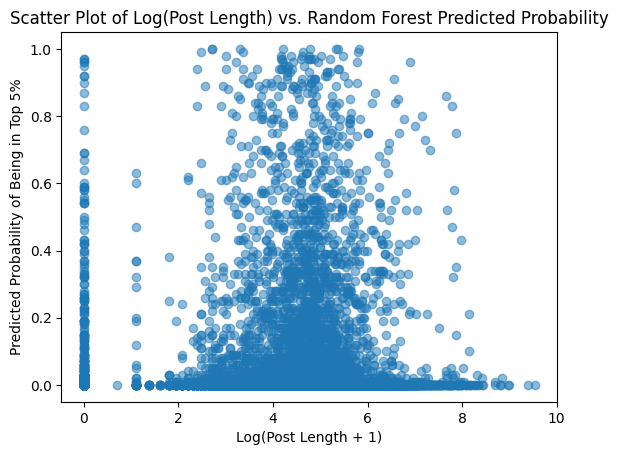

In [ ]:
# plot log post length against the prediced probability
post_length = np.log(x_test['Post Length'] + 1)
probabilities = rf_classifier.predict_proba(x_test)[:, 1]

plt.scatter(post_length, probabilities, alpha=0.5)
plt.xlabel("Log(Post Length + 1)")
plt.ylabel("Predicted Probability of Being in Top 5%")
plt.title("Scatter Plot of Log(Post Length) vs. Random Forest Predicted Probability")
plt.show()

From the pattern it looks like there is some signs of a normal distribution with post lenght and predicted probability of being in the top 5. We can see that there is a lot of tweets that are super short with a log(post length + 1) value of almost 0 and some have a high probability of being in the top 5 and some have a low. There is no distinct pattern when it comes to how long a tweet should be if you want the probability of being in the top 5 to be higher, but it does seem like you don't want the tweet to be super long and generally the tweets with the highest probability of being top 5 % have average length and are between a log(post length +1) value of 2.5 and 6.

# Question 3 - Image classification and sample size

This question isnt really about image classification. This question is about how models improve with increasing amounts of training data. We will fit two models (random forest and logistic regression) to the CIFAR10 dataset of natural images.
* https://www.cs.toronto.edu/~kriz/cifar.html

Our goal is to see how (or if) test error metrics improve with increasing levels of training data and how that differs by model.

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

from tqdm.notebook import tqdm
from tqdm.notebook import trange

In [ ]:
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

100%|██████████| 170498071/170498071 [00:01<00:00, 105308002.79it/s]


Extracting data/cifar-10-python.tar.gz to data


### Part a

Loop through the `training_data` object and extract all of the images (flattened to a vector) and the labels.

1. Extract all images. Flatten them to vectors and store in the matrix `x`.
2. Extract the associated class labels. Store them in the vector `y`.

In [ ]:
x = np.zeros((50000, 3*32*32))
y = np.zeros(50000)


for i in trange(len(training_data)):
  img, label = training_data[i]
  x[i] = img.view(-1).numpy()
  y[i] = label

  0%|          | 0/50000 [00:00<?, ?it/s]

## Part b

We will train two models 3 times each to see how increasing the training sample size can help improve out of sample performance.

1. Train a random forest and a logistic regression on 1\% of the data. Save the brier score, accuracy and average F1 score of each model.
2. Repeat step 1 but train on 5\% of the data.
3. Repeat step 1 but train on 25% of the data (slow).

In [ ]:
percents = [0.01, 0.05, 0.25]
results = []
brier_rf = []
brier_logistic = []
accuracy_rf = []
accuracy_logistic = []
f1_rf = []
f1_logistic = []

for percent in percents:
    x_train, x_test, y_train, y_test = train_test_split(x[:int(len(x) * percent)], y[:int(len(x) * percent)], test_size=0.33, random_state=42)

    rf_classifier = RandomForestClassifier(random_state=42)
    rf_classifier.fit(x_train, y_train)
    logistic_classifier = LogisticRegression(random_state=42)
    logistic_classifier.fit(x_train, y_train)

    rf_labels = rf_classifier.predict(x_test)
    logistic_labels = logistic_classifier.predict(x_test)
    rf_probabilities = rf_classifier.predict_proba(x_test)
    logistic_probabilities = logistic_classifier.predict_proba(x_test)

    rf_brier = np.round(brier_score(y_test, rf_probabilities), 3)
    log_brier = np.round(brier_score(y_test, logistic_probabilities), 3)

    rf_accuracy = metrics.classification_report(y_test, rf_labels, output_dict=True)['accuracy']
    logistic_accuracy = metrics.classification_report(y_test, logistic_labels, output_dict=True)['accuracy']

    rf_f1 = metrics.classification_report(y_test, rf_labels, output_dict=True)['weighted avg']['f1-score']
    logistic_f1 = metrics.classification_report(y_test, logistic_labels, output_dict=True)['weighted avg']['f1-score']

    brier_rf.append(rf_brier)
    brier_logistic.append(log_brier)
    accuracy_rf.append(rf_accuracy)
    accuracy_logistic.append(logistic_accuracy)
    f1_rf.append(rf_f1)
    f1_logistic.append(logistic_f1)

    result = {
        "Percent": percent,
        "RF Brier": rf_brier,
        "Logistic Brier": log_brier,
        "RF Accuracy": rf_accuracy,
        "Logistic Accuracy": logistic_accuracy,
        "RF F1": rf_f1,
        "Logistic F1": logistic_f1
    }

    results.append(result)

output = pd.DataFrame(results)
print(output)

   Percent  RF Brier  Logistic Brier  RF Accuracy  Logistic Accuracy  \
0     0.01     0.832           1.072     0.248485           0.242424   
1     0.05     0.771           0.908     0.386667           0.339394   
2     0.25     0.752           0.775     0.402424           0.364364   

      RF F1  Logistic F1  
0  0.231371     0.237148  
1  0.379940     0.335078  
2  0.398453     0.362997  


## Part c

Now lets compare how each model performed as we increased the amount of training data available.

1. Plot the brier score for each model as a function of training sample size. Color code each line by model type (randomforest and logistic regression).
2. Repeat for Accuracy and F1 score metrics. Combine all three plots into a single multi-panel (1 row, 3 col) plot.
3. Which model seemed to improve the most with increasing sample size? Answer using all of the plotted metrics.
The Random Forest Model improved the most with larger sample size as the accuracy and F1 went up higher than logistic and the brier score was lower.
4. Does this make sense given what we know about parametric and nonparametric models? Why might one of these models be benefitting more from having more training data?
Yes this makes sense that the random forest model improves more with more available data because random forest is nonparametric model and logistic is parametric. Non parametric models benefit from more data because they capture more complex non-linear relationships in the data while parametric models have a linear decision boundary which limits the ability to find inticate patterns.
5. Are any of these models close in accuracy to the baselines listed on the CIFAR10 page?
None of these models seem to be all that close to how accurate some of the models on the CIFAR10 page are unless I am interpretating the CIFAR10 page incorrectly. Our models likely need a lot more tuning and more data available.

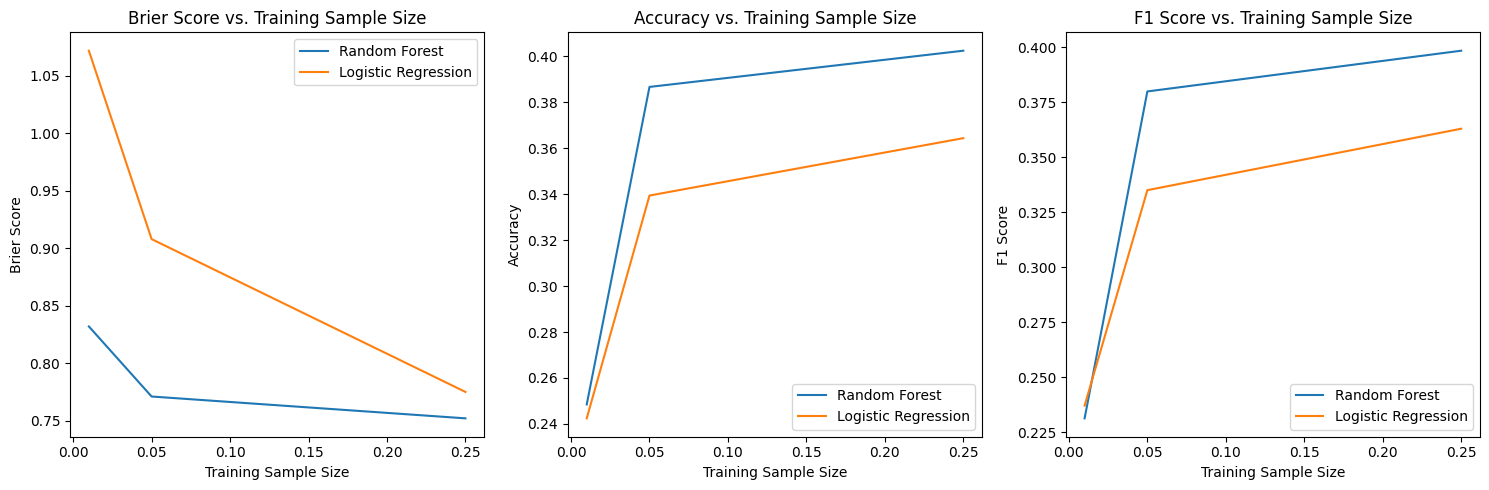

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Brier Score
axes[0].plot(percents, brier_rf, label="Random Forest")
axes[0].plot(percents, brier_logistic, label="Logistic Regression")
axes[0].set_xlabel("Training Sample Size")
axes[0].set_ylabel("Brier Score")
axes[0].set_title("Brier Score vs. Training Sample Size")
axes[0].legend()

# Accuracy
axes[1].plot(percents, accuracy_rf, label="Random Forest")
axes[1].plot(percents, accuracy_logistic, label="Logistic Regression")
axes[1].set_xlabel("Training Sample Size")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Accuracy vs. Training Sample Size")
axes[1].legend()

# F1 Score
axes[2].plot(percents, f1_rf, label="Random Forest")
axes[2].plot(percents, f1_logistic, label="Logistic Regression")
axes[2].set_xlabel("Training Sample Size")
axes[2].set_ylabel("F1 Score")
axes[2].set_title("F1 Score vs. Training Sample Size")
axes[2].legend()

plt.tight_layout()
plt.show()